### Урок 7

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [2]:
# Расчет медианы по группам категории
def code_median(df, cat_feature, real_feature):
    return (df[cat_feature].map(df.groupby(cat_feature)[real_feature].median()))

In [3]:
# Расчет средней по группам категории
def code_mean(df, cat_feature, real_feature):
    return (df[cat_feature].map(df.groupby(cat_feature)[real_feature].mean()))

### 1.  Взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

In [4]:
train_df = pd.read_csv('train.csv')
train_df.head(3)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1
2,2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0


In [5]:
predict_df = pd.read_csv('test.csv')
predict_df.head(3)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,10000,32.0,2.0,2700.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0
1,10001,35.0,6.0,1800.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,71.0
2,10002,44.0,2.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0


In [6]:
example = pd.read_csv('submission_example.csv')
example.head(3)

,Id,choose
0,10000,0.5
1,10001,0.5
2,10002,0.5


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
 12  choose               10000 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 1015.8 KB


In [8]:
train_df = train_df.rename(columns={'years_of_experience': 'experience', 'lesson_price': 'price', 'mean_exam_points': 'points'})
predict_df = predict_df.rename(columns={'years_of_experience': 'experience', 'lesson_price': 'price', 'mean_exam_points': 'points'})

### 2. Сделать обзорный анализ выбранного датасета

#### Целевая переменная

In [9]:
train_df.choose.value_counts()

0    8891
1    1109
Name: choose, dtype: int64

У нас очень несбалансированная выборка. Сбалансируем его, создав дубликаты наименее представленного класса.

In [10]:
p = len(train_df.loc[train_df['choose'] == 1])
n = len(train_df.loc[train_df['choose'] == 0])

In [11]:
for i in range(int(n/p)):
    sample = train_df[train_df['choose'] == 1].sample(p)
    train_df = train_df.append(sample, ignore_index=True)

In [12]:
train_df.choose.value_counts()

1    9981
0    8891
Name: choose, dtype: int64

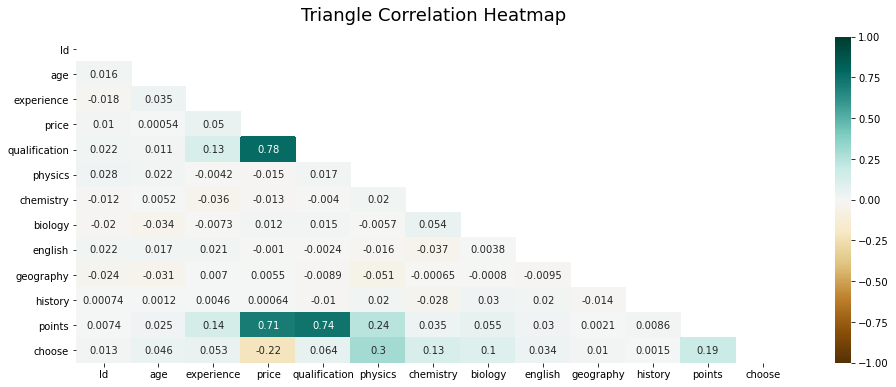

In [13]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(train_df.corr(), dtype=np.bool)) 
heatmap = sns.heatmap(train_df.corr(), annot=True, vmin=-1, vmax=1, mask = mask, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

#### Age

In [14]:
age_mean = round(train_df['age'].mean(), 2)
age_median = train_df['age'].median()
age_mode = train_df['age'].mode()[0]
print(f'mean - {age_mean}, median - {age_median}, mode - {age_mode}')

mean - 46.15, median - 46.0, mode - 44.0


Text(0.5, 1.0, 'Распределение репетиторов по возрасту')

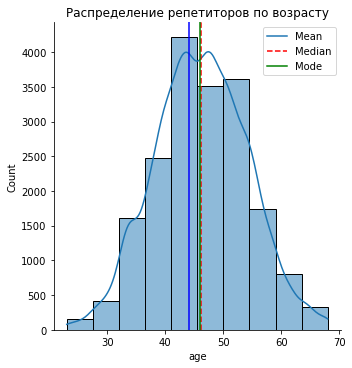

In [15]:
sns.displot(train_df['age'], bins=10, kde=True)
plt.axvline(age_mean, color='r', linestyle='--')
plt.axvline(age_median, color='g', linestyle='-')
plt.axvline(age_mode, color='b', linestyle='-')
plt.legend({'Mean':age_mean,'Median':age_median,'Mode':age_mode})
plt.title('Распределение репетиторов по возрасту')

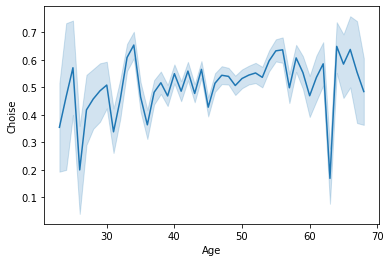

In [16]:
lineplot = sns.lineplot(x = 'age', y ='choose', data=train_df)
lineplot.set_xlabel('Age');
lineplot.set_ylabel ('Choise');

In [17]:
train_df['age_group'] = pd.cut(train_df['age'], bins=[1, 30, 40, 50, 60, 100], labels=[1,2,3,4,5], right=False).astype('float')
predict_df['age_group'] = pd.cut(predict_df['age'], bins=[1, 30, 40, 50, 60, 100], labels=[1,2,3,4,5], right=False).astype('float')

#### Experience

In [18]:
exp_mean = round(train_df['experience'].mean(), 2)
exp_median = train_df['experience'].median()
exp_mode = train_df['experience'].mode()[0]
print(f'mean - {exp_mean}, median - {exp_median}, mode - {exp_mode}')

mean - 2.06, median - 2.0, mode - 0.0


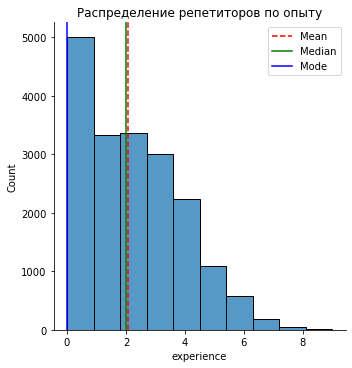

In [19]:
sns.displot(train_df['experience'], bins=10)
plt.axvline(exp_mean, color='r', linestyle='--')
plt.axvline(exp_median, color='g', linestyle='-')
plt.axvline(exp_mode, color='b', linestyle='-')
plt.legend({'Mean':exp_mean,'Median':exp_median,'Mode':exp_mode})
plt.title('Распределение репетиторов по опыту');

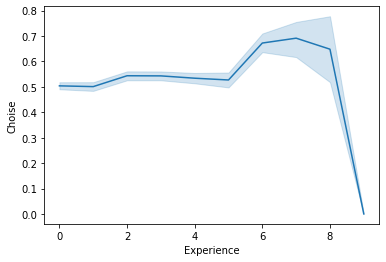

In [20]:
lineplot = sns.lineplot(x = 'experience', y ='choose', data=train_df)
lineplot.set_xlabel('Experience');
lineplot.set_ylabel ('Choise');

In [21]:
train_df['exp_group'] = pd.cut(train_df['experience'], bins=[0, 2, 5, 8, 15], labels=[1,2,3,4], right=False).astype('float')
predict_df['exp_group'] = pd.cut(predict_df['experience'], bins=[0, 2, 5, 8, 15], labels=[1,2,3,4], right=False).astype('float')

<font color='red'> Проверить будет ли изменение, если поменять границы групп (в частности куда отнести 8)

In [22]:
train_df['qualification_by_exp'] = code_median(train_df, 'experience', 'qualification')
predict_df['qualification_by_exp'] = code_median(predict_df, 'experience', 'qualification')

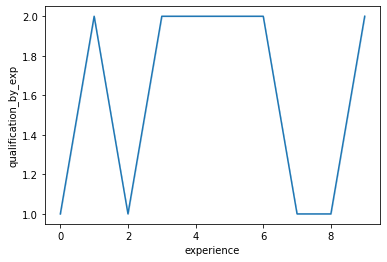

In [23]:
lineplot = sns.lineplot(x = 'experience', y ='qualification_by_exp', data=train_df)
lineplot.set_xlabel('experience');
lineplot.set_ylabel ('qualification_by_exp');

In [24]:
train_df['price_by_exp'] = code_median(train_df, 'experience', 'price')
predict_df['price_by_exp'] = code_median(predict_df, 'experience', 'price')

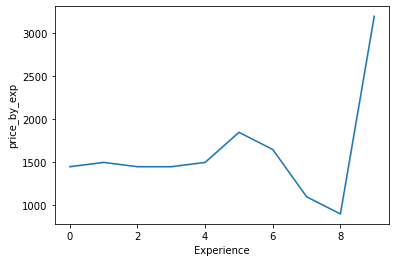

In [25]:
lineplot = sns.lineplot(x = 'experience', y ='price_by_exp', data=train_df)
lineplot.set_xlabel('Experience');
lineplot.set_ylabel ('price_by_exp');

In [26]:
train_df['age_by_exp_group'] = code_median(train_df, 'exp_group', 'age')
predict_df['age_by_exp_group'] = code_median(predict_df, 'exp_group', 'age')

In [27]:
train_df['price_by_exp_group'] = code_median(train_df, 'exp_group', 'price')
predict_df['price_by_exp_group'] = code_median(predict_df, 'exp_group', 'price')

#### Price

In [28]:
price_mean = round(train_df['price'].mean(), 2)
price_median = train_df['price'].median()
price_mode = train_df['price'].mode()[0]
print(f'mean - {price_mean}, median - {price_median}, mode - {price_mode}')

mean - 1609.96, median - 1450.0, mode - 1300.0


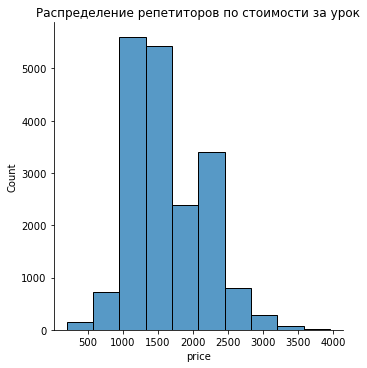

In [29]:
sns.displot(train_df['price'], bins=10)
plt.title('Распределение репетиторов по стоимости за урок');

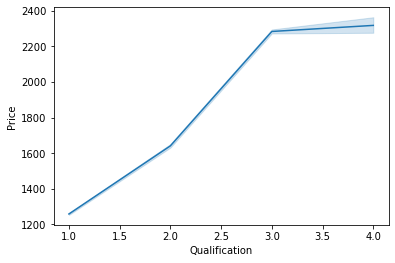

In [30]:
lineplot = sns.lineplot(x = 'qualification', y ='price', data=train_df)
lineplot.set_xlabel('Qualification');
lineplot.set_ylabel ('Price');

In [31]:
train_df['price_group'] = pd.cut(train_df['price'], bins=[0, 1800, 2000, 2200, 2400, 10000], labels=[1,2,3,4,5],right=False).astype('float')
predict_df['price_group'] = pd.cut(predict_df['price'], bins=[0, 1800, 2000, 2200, 2400, 10000], labels=[1,2,3,4,5],right=False).astype('float')

In [32]:
train_df['price_by_qulification'] = code_median(train_df, 'qualification', 'price')
predict_df['price_by_qulification'] = code_median(predict_df, 'qualification', 'price')

#### Qualification

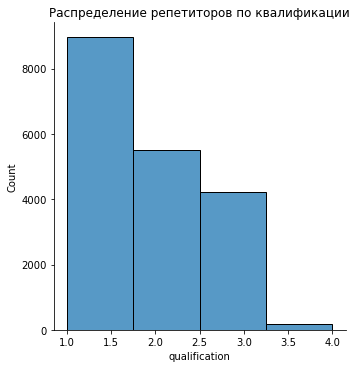

In [33]:
sns.displot(train_df['qualification'], bins=4)
plt.title('Распределение репетиторов по квалификации');

In [34]:
train_df['exp_by_qualification'] = code_median(train_df, 'qualification', 'experience')
predict_df['exp_by_qualification'] = code_median(predict_df, 'qualification', 'experience')

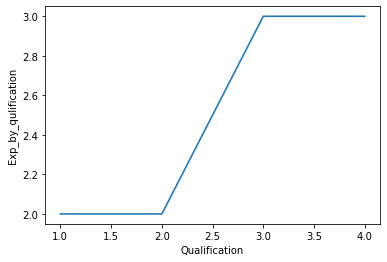

In [35]:
lineplot = sns.lineplot(x = 'qualification', y ='exp_by_qualification', data=train_df)
lineplot.set_xlabel('Qualification');
lineplot.set_ylabel ('Exp_by_qulification');

### Science

In [36]:
train_df['science_1'] = \
np.where(((train_df['physics'] == 1) | (train_df['chemistry'] == 1) | (train_df['biology'] == 1) | (train_df['geography'] == 1)), \
         (train_df['physics'] + train_df['chemistry'] + train_df['biology'] + train_df['geography']), 0)

In [37]:
predict_df['science_1'] = \
np.where(((predict_df['physics'] == 1) | (predict_df['chemistry'] == 1) | (predict_df['biology'] == 1) | (predict_df['geography'] == 1)), \
         (predict_df['physics'] + predict_df['chemistry'] + predict_df['biology'] + predict_df['geography']), 0)

In [38]:
train_df['science_2'] = \
np.where(((train_df['physics'] == 1) | (train_df['chemistry'] == 1) | (train_df['biology'] == 1) | (train_df['geography'] == 1)), \
         1, 0)

In [39]:
predict_df['science_2'] = \
np.where(((predict_df['physics'] == 1) | (predict_df['chemistry'] == 1) | (predict_df['biology'] == 1) | (predict_df['geography'] == 1)), \
         1, 0)

In [40]:
train_df['science_3'] = \
np.where(((train_df['physics'] == 1) | (train_df['chemistry'] == 1) | (train_df['biology'] == 1)), 1, 0)

In [41]:
predict_df['science_3'] = \
np.where(((predict_df['physics'] == 1) | (predict_df['chemistry'] == 1) | (predict_df['biology'] == 1)), 1, 0)

### Points

In [42]:
points_mean = round(train_df['points'].mean(), 2)
points_median = train_df['points'].median()
points_mode = train_df['points'].mode()[0]
print(f'mean - {points_mean}, median - {points_median}, mode - {points_mode}')

mean - 66.47, median - 65.0, mode - 67.0


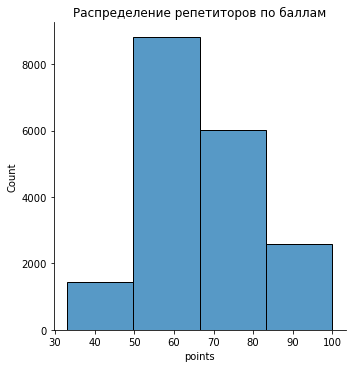

In [43]:
sns.displot(train_df['points'], bins=4)
plt.title('Распределение репетиторов по баллам');

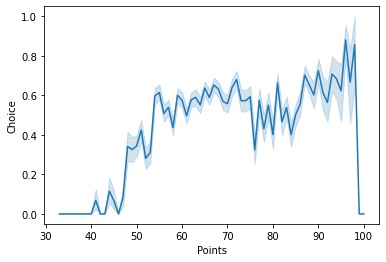

In [44]:
lineplot = sns.lineplot(x = 'points', y ='choose', data=train_df)
lineplot.set_xlabel('Points');
lineplot.set_ylabel ('Choice');

In [45]:
train_df['points_group'] = pd.cut(train_df['points'], bins=[0, 45, 55, 75, 85, 101], labels=[1,2,3,4,5], right=False).astype('float')
predict_df['points_group'] = pd.cut(predict_df['points'], bins=[0, 45, 55, 75, 85, 101], labels=[1,2,3,4,5], right=False).astype('float')

In [46]:
train_df['points_by_exp'] = code_median(train_df, 'experience', 'points')
predict_df['points_by_exp'] = code_median(predict_df, 'experience', 'points')

In [47]:
train_df['points_by_qualification'] = code_median(train_df, 'qualification', 'points')
predict_df['points_by_qualification'] = code_median(predict_df, 'qualification', 'points')

In [48]:
train_df['points_by_age_group'] = code_median(train_df, 'age_group', 'points')
predict_df['points_by_age_group'] = code_median(predict_df, 'age_group', 'points')

In [49]:
train_df['points_by_price_group'] = code_median(train_df, 'price_group', 'points')
predict_df['points_by_price_group'] = code_median(predict_df, 'price_group', 'points')

In [50]:
train_df['points'].loc[train_df['points_group'].isna() == True]

Series([], Name: points, dtype: float64)

In [51]:
train_df.head()

,Id,age,experience,price,qualification,physics,chemistry,biology,english,geography,...,price_by_qulification,exp_by_qualification,science_1,science_2,science_3,points_group,points_by_exp,points_by_qualification,points_by_age_group,points_by_price_group
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1600.0,2.0,0.0,0,0,3.0,64.0,65.0,65.0,79.0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,...,1600.0,2.0,2.0,1,1,3.0,65.0,65.0,66.0,61.0
2,2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1250.0,2.0,1.0,1,1,3.0,64.0,60.0,66.0,61.0
3,3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1250.0,2.0,0.0,0,0,3.0,64.0,60.0,65.0,61.0
4,4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,...,1600.0,2.0,1.0,1,1,3.0,64.0,65.0,65.0,83.0


### 3. Сделать feature engineering

In [52]:
#train_df.info()

In [53]:
#train_df.columns

In [54]:
categorical_columns = []
for col in train_df.columns:
    if train_df[col].dtype.kind == 'O':
        categorical_columns.append(col)

categorical_columns

[]

In [55]:
cols_to_drop = ['Id', 'choose', 'physics', 'chemistry', 'biology', 'english', 'geography', 'history', 'science_1',
       'science_2', 'science_3']
cols = list(set(train_df.columns) - set(cols_to_drop) - set(categorical_columns))
base_cols = cols

In [80]:
# генерируем признаки
def transform_data(data):
    for i1, col1 in enumerate(base_cols):
        data[col1 + '_log'] = np.log(data[col1] + 1.1)
      #  data[col1 + '_Reciprocal'] = 1/(data[col1] + 1.1)
        data[col1 + '_root'] = np.power(data[col1], 1/3)
        data[col1 + '_sqroot'] = np.power(data[col1], 1/2)
        data[col1 + '_pow'] = np.power(data[col1], 2)
        
        for i2, col2 in enumerate(base_cols):
            data['%s_%s_1' % (col1, col2)] = data[col1] - data[col2]
        #    data['%s_%s_2' % (col1, col2)] = data[col1] + data[col2]
        #    data['%s_%s_3' % (col1, col2)] = data[col1] / (data[col2] + 0.1)
        #    data['%s_%s_4' % (col1, col2)] = data[col1] * data[col2]

           # data['%s_%s_11' % (col1, col2)] = data[col1] - np.log(data[col2] + 1)
           # data['%s_%s_22' % (col1, col2)] = data[col1] + np.log(data[col2] + 1)
           # data['%s_%s_33' % (col1, col2)] = data[col1] / (np.log(data[col2] + 1) + 0.1)
           # data['%s_%s_44' % (col1, col2)] = data[col1] * np.log(data[col2] + 1)
    return data

In [81]:
import time
from tqdm import tqdm

for i in tqdm(range(100)):
    time.sleep(0.1)
    train_tr = transform_data(train_df.drop(columns=['Id', 'choose']))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.39s/it]


In [82]:
for i in tqdm(range(100)):
    time.sleep(0.1)
    predict_tr = transform_data(predict_df.drop(columns=['Id']))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/it]


In [3446]:
#train_scaled = StandardScaler().fit_transform(train_tr)
#predict_scaled = StandardScaler().fit_transform(predict_tr)

4. Обучить любой классификатор (какой вам нравится)

In [3447]:
#X = train_df.drop(columns=['Id', 'choose'])
#y = train_df['choose']

In [3448]:
#X_predict = predict_df.drop(columns=['Id'])

In [83]:
X = train_tr
y = train_df['choose']
X_predict = predict_tr

In [84]:
X.shape, y.shape

((18872, 465), (18872,))

In [85]:
X_train_b, X_test_b, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [86]:
X_train_b.shape, y_train.shape, X_test_b.shape, y_test.shape

((13210, 465), (13210,), (5662, 465), (5662,))

In [87]:
features_base = train_tr.columns
features_base.tolist()

['age',
 'experience',
 'price',
 'qualification',
 'physics',
 'chemistry',
 'biology',
 'english',
 'geography',
 'history',
 'points',
 'age_group',
 'exp_group',
 'qualification_by_exp',
 'price_by_exp',
 'age_by_exp_group',
 'price_by_exp_group',
 'price_group',
 'price_by_qulification',
 'exp_by_qualification',
 'science_1',
 'science_2',
 'science_3',
 'points_group',
 'points_by_exp',
 'points_by_qualification',
 'points_by_age_group',
 'points_by_price_group',
 'price_by_exp_group_log',
 'price_by_exp_group_root',
 'price_by_exp_group_sqroot',
 'price_by_exp_group_pow',
 'price_by_exp_group_price_by_exp_group_1',
 'price_by_exp_group_price_group_1',
 'price_by_exp_group_age_group_1',
 'price_by_exp_group_price_1',
 'price_by_exp_group_points_by_price_group_1',
 'price_by_exp_group_points_by_qualification_1',
 'price_by_exp_group_points_1',
 'price_by_exp_group_points_by_age_group_1',
 'price_by_exp_group_experience_1',
 'price_by_exp_group_points_group_1',
 'price_by_exp_group

In [183]:
features_selection = features_rank

In [190]:
X_train = X_train_b[features_selection].to_numpy()
X_test = X_test_b[features_selection].to_numpy()
X_train.shape, X_test.shape

((13210, 60), (5662, 60))

In [191]:
X_predict = predict_tr
X_predict = X_predict[features_selection].to_numpy()
X_predict.shape

(10000, 60)

In [93]:
rfe = RFE(estimator=LogisticRegression(max_iter = 10000), n_features_to_select=60)
X_new = rfe.fit_transform(train_tr[features_base], train_df['choose'])

In [144]:
features_rank = []
for i in range(len(features_base)):
    if rfe.ranking_[i] == 1:
        features_rank.append(features_base[i])

len(features_rank)
for i in enumerate(features_rank):
    print(f'{i},')

(0, 'physics'),
(1, 'science_1'),
(2, 'science_2'),
(3, 'science_3'),
(4, 'price_by_exp_group_experience_1'),
(5, 'price_by_exp_group_qualification_1'),
(6, 'price_by_exp_group_exp_by_qualification_1'),
(7, 'price_group_pow'),
(8, 'price_sqroot'),
(9, 'price_experience_1'),
(10, 'price_qualification_1'),
(11, 'points_by_price_group_points_by_age_group_1'),
(12, 'points_by_price_group_qualification_1'),
(13, 'points_by_price_group_age_by_exp_group_1'),
(14, 'points_by_price_group_points_by_exp_1'),
(15, 'points_by_qualification_points_1'),
(16, 'points_by_qualification_qualification_1'),
(17, 'points_points_by_qualification_1'),
(18, 'points_experience_1'),
(19, 'points_qualification_1'),
(20, 'points_exp_by_qualification_1'),
(21, 'points_age_by_exp_group_1'),
(22, 'points_qualification_by_exp_1'),
(23, 'points_by_age_group_points_by_price_group_1'),
(24, 'points_by_age_group_qualification_1'),
(25, 'points_by_age_group_price_by_qulification_1'),
(26, 'experience_price_by_exp_group_1')

#### Создание pipeline

In [96]:
# класс для выбора нужного признака
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

# класс для выбора числовых признаков 
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
# класс создания дамми-переменных 
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [97]:
#continuous_columns = list(set(X_train.columns) - set(categorical_columns))

<font color = 'red'> Проведем преобразование категориальных переменных в дамми, и пока ничего не сделаем в числовыми признаками. НАДО ДОБАВИТЬ СТАНДАРТИЗАЦИЮ.

In [98]:
#final_transformers = list()
#
#for cat_col in categorical_columns:
#    cat_transformer = Pipeline([
#                ('selector', FeatureSelector(column=cat_col)),
#                ('ohe', OHEEncoder(key=cat_col))
#            ])
#    final_transformers.append((cat_col, cat_transformer))
#    
#for cont_col in continuous_columns:
#    cont_transformer = Pipeline([
#                ('selector', NumberSelector(key=cont_col))
#            ])
#    final_transformers.append((cont_col, cont_transformer))

In [99]:
#categorical_columns2 = []
#for col in X_train.columns:
#    if X_train[col].dtype.kind != 'f' and X_train[col].dtype.kind != 'i' :
#        categorical_columns2.append(col)
    
#categorical_columns2

In [100]:
#final_transformers = list(set(final_transformers) - set(categorical_columns2))

Теперь объединим все преобразованные признаки в единый pipeline:

In [101]:
#feats = FeatureUnion(final_transformers)
#feature_processing = Pipeline([('feats', feats)])

In [102]:
#pipeline = Pipeline([
#    ('features', feats),
#    ('normalizer', StandardScaler()),
#    ('classifier', LogisticRegression(random_state = 42, max_iter = 10000))
# ])

In [103]:
#pipeline.fit(X_train, y_train)

In [192]:
logreg = LogisticRegression(random_state = 42, max_iter = 10000)
#rfe = RFE(logreg, n_features_to_select=20)
#rfe = rfe.fit(X, y)
#print(rfe.support_)
#print(rfe.ranking_)

In [193]:
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [194]:
y_pred_test = logreg.predict(X_test)

In [195]:
logreg.score(X_train, y_train)

0.7725965177895534

In [196]:
logreg.score(X_test, y_test)

0.7850582832921229

In [197]:
preds = logreg.predict_proba(X_test)[:, 1]

In [110]:
#наши прогнозы для тестовой выборки
#preds = pipeline.predict_proba(X_test)[:, 1]
#preds[:10]

In [111]:
#precision, recall, thresholds = precision_recall_curve(y_test, preds)

#fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
#ix = np.argmax(fscore)
#print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
#                                                                        fscore[ix],
#                                                                        precision[ix],
#                                                                        recall[ix]))

In [112]:
#pipeline.score(X_train, y_train)

In [113]:
#pipeline.score(X_test, y_test)

In [114]:
# Best Threshold=0.258894, F-Score=0.479, Precision=0.454, Recall=0.507
# 0.901
# 0.8953333333333333

# Best Threshold=0.209787, F-Score=0.455, Precision=0.378, Recall=0.573
# 0.905
# 0.8923333333333333

# Best Threshold=0.216553, F-Score=0.465, Precision=0.393, Recall=0.568
# 0.9025714285714286
# 0.8926666666666667

In [115]:
#params = \
#     {'classifier__penalty': ['l2', 'none'],
#      'classifier__solver': ['lbfgs'], 
#      'classifier__max_iter': [100]}

#grid_search = GridSearchCV(pipe, params)

In [116]:
#grid_search.fit(X_train, y_train)
#print(grid_search.score(X_test, y_test)) #0.982122905027933
#grid_search.best_params_

In [117]:
#pipeline = Pipeline([
#    ('features', feats),
#    ('normalizer', StandardScaler()),
#    ('classifier', LogisticRegression(random_state = 42, max_iter = 300, penalty = 'none', solver = 'lbfgs')),
#])

In [118]:
#pipeline.fit(X_train, y_train)

In [119]:
#наши прогнозы для тестовой выборки
#preds = pipeline.predict_proba(X_test)[:, 1]
#preds[:10]

In [120]:
#precision, recall, thresholds = precision_recall_curve(y_test, preds)
#fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
#ix = np.argmax(fscore)
# print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
#                                                                        fscore[ix],
#                                                                        precision[ix],
#                                                                        recall[ix]))

In [121]:
#pipeline.score(X_train, y_train)

In [122]:
#pipeline.score(X_test, y_test)

5. Разобраться с SHAP и построить важности признаков для: <br>
- всего тестового набора данных (summary_plot - дать интерпретацию) <br>
- для топ 10% <br>
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат <br>

In [198]:
import shap
shap.initjs()

In [199]:
explainer = shap.Explainer(logreg, X_train, feature_names=features_selection)
shap_values = explainer(X_test)

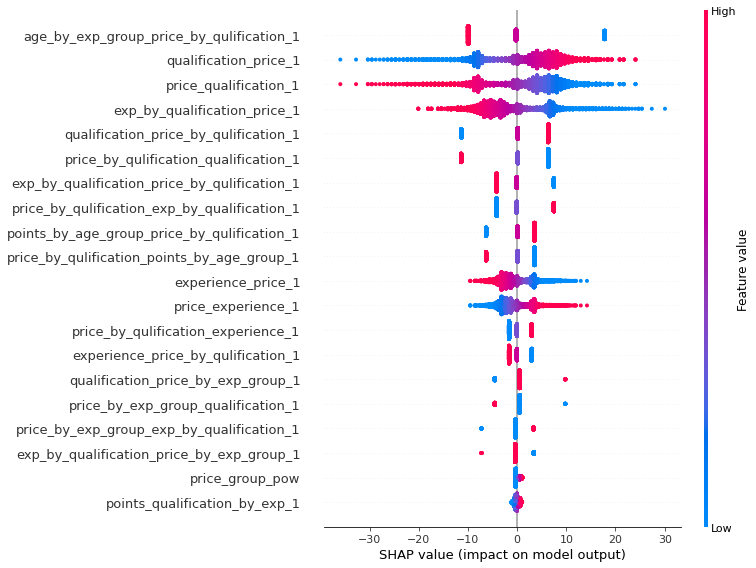

In [202]:
shap.summary_plot(shap_values, X_test, max_display=20)

Слева от центральной линии - negative class, справа - positive class. Чем толще линия на графике, тем больше таких точек наблюдения. Чем краснее точки на графике, тем выше значения фичи в ней.

In [213]:
shap.force_plot(explainer.expected_value, shap_values.values[10,:], X_test[10,:])

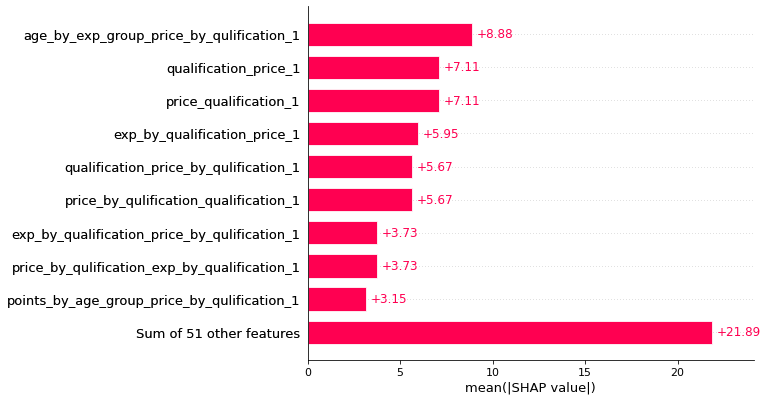

In [232]:
shap.plots.bar(shap_values)

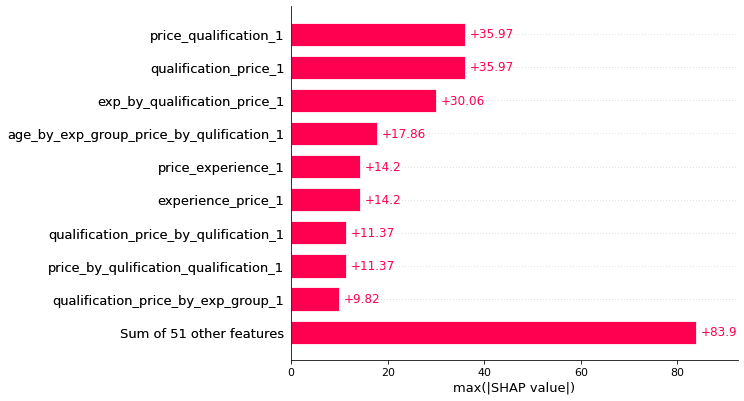

In [233]:
shap.plots.bar(shap_values.abs.max(0))

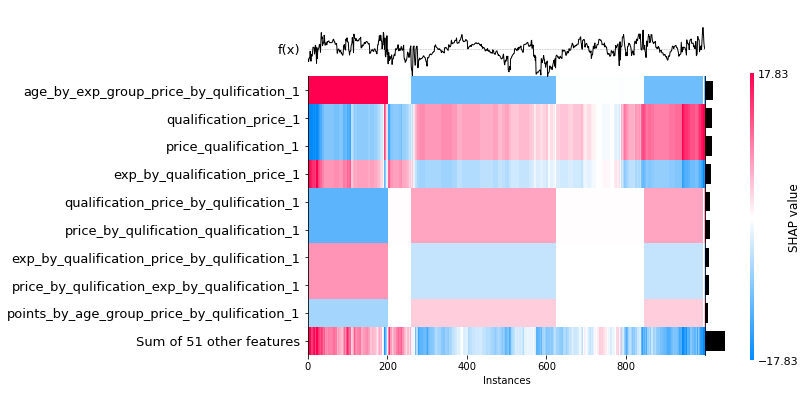

In [234]:
shap.plots.heatmap(shap_values[:1000])

### Формирование файла с ответами:

In [137]:
#y_pred = pipeline.predict(X_predict)

In [203]:
y_pred = logreg.predict(X_predict)

In [204]:
submit = pd.concat([predict_df['Id'], pd.Series(y_pred)], axis = 1)
submit = submit.rename(columns = {0 : 'choose'})

In [205]:
submit.to_csv('LogLoss_predict.csv', index=None)

In [141]:
submit.head(15)

,Id,choose
0,10000,0
1,10001,0
2,10002,0
3,10003,0
4,10004,1
5,10005,1
6,10006,0
7,10007,1
8,10008,0
9,10009,1


In [142]:
#0.57929
#0.58115
#0.62806
#0.60495
#0.74462
#0.72572
#0.71258
#0.72609 - 61 признак
#0.73307 - 30 признаков
#0.74752 - 15 признаков

# 0.72702 - 3011 признаков
# 0.75359 - 465 признаков
# 0.73279 - 60 признаков